### This notebook is made by Laxman Kumar as part of submission for CIS 731 ANN Homework 1.

NOTE : All the computations are made on laptop with Intel i3 2.0 GHz processor and 12 GB RAM. Also, there was no GPU involved in the computation, all the computation are made using CPU only.

### Importing necessary libraries here

In [191]:
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
from torch.utils import data as T
import torch
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.patches as mpatches

In [24]:
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, r2_score
import time

<b>Data Set Information</b>

This data set measures the running time of a matrix-matrix product A*B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).


<b>Attribute Information</b>

- Independent variables:
1-2. MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
3. KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
4-5. MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
6-7. MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
8. KWI: kernel loop unrolling factor: {2, 8} (integer)
9-10. VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
11-12. STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
13-14. SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

- Output:
15-18. Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance

In [2]:
df = pd.read_csv("sgemm_product.csv",sep=",")
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


### Since we have 4 column of runtime, we will merge all the column into a new column named "Runtime" which will have mean of the four individual runtime

In [3]:
#creating Runtime, target variable by taking average of Run1, Run2, Run3, Run4
df['Runtime']=df[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)
df=df.drop(columns =['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'], axis = 1)

In [4]:
#drop other Run time variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
MWG        241600 non-null int64
NWG        241600 non-null int64
KWG        241600 non-null int64
MDIMC      241600 non-null int64
NDIMC      241600 non-null int64
MDIMA      241600 non-null int64
NDIMB      241600 non-null int64
KWI        241600 non-null int64
VWM        241600 non-null int64
VWN        241600 non-null int64
STRM       241600 non-null int64
STRN       241600 non-null int64
SA         241600 non-null int64
SB         241600 non-null int64
Runtime    241600 non-null float64
dtypes: float64(1), int64(14)
memory usage: 27.6 MB


By looking at above information, we can make sure that there are no null values in the dataset.

In [5]:
df.isnull().sum()

MWG        0
NWG        0
KWG        0
MDIMC      0
NDIMC      0
MDIMA      0
NDIMB      0
KWI        0
VWM        0
VWN        0
STRM       0
STRN       0
SA         0
SB         0
Runtime    0
dtype: int64

### df.describe method gives us the necessary statistics information of all the available features in the dataset

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.00,128.0000,128.0000
NWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.00,128.0000,128.0000
KWG,241600.0,25.513113,7.855619,16.0000,16.0000,32.00,32.0000,32.0000
MDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.00,16.0000,32.0000
NDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.00,16.0000,32.0000
MDIMA,241600.0,17.371126,9.389418,8.0000,8.0000,16.00,32.0000,32.0000
NDIMB,241600.0,17.371126,9.389418,8.0000,8.0000,16.00,32.0000,32.0000
KWI,241600.0,5.000000,3.000006,2.0000,2.0000,5.00,8.0000,8.0000
VWM,241600.0,2.448609,1.953759,1.0000,1.0000,2.00,4.0000,8.0000
VWN,241600.0,2.448609,1.953759,1.0000,1.0000,2.00,4.0000,8.0000


### Below is the boxplot of runtime column, which is our target variable. Using boxplot we can easily know about the outlinears and where our most data lies.

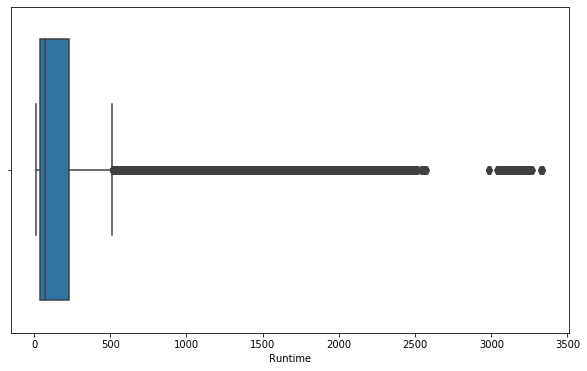

In [9]:
#checking for outliers
plt.figure(figsize=(10,6))
sns.boxplot(df['Runtime']);

In [10]:
df.Runtime.quantile([0.25,0.5,0.75])

0.25     40.6675
0.50     69.7900
0.75    228.3875
Name: Runtime, dtype: float64

From the above boxplot, we can notice that the our first 3 quratiles are 40, 70 and 239 respectively. But some of our values reach to the far end of 3500.

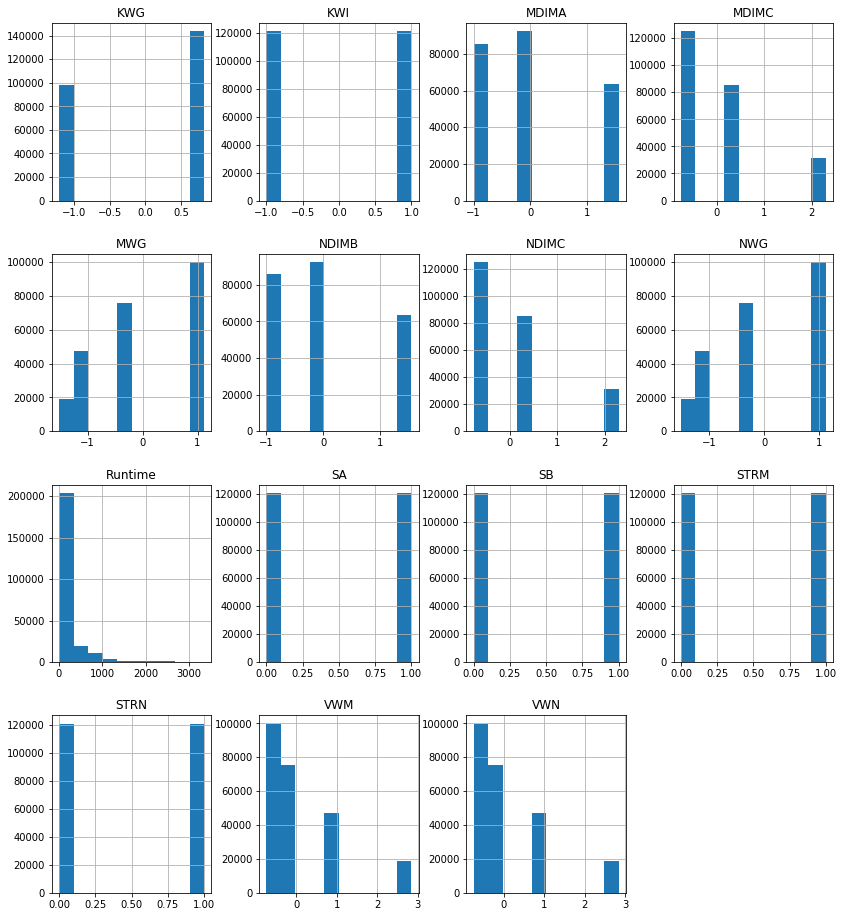

In [11]:
for index in range(10):
    df.iloc[:,index] = (df.iloc[:,index]-df.iloc[:,index].mean()) / df.iloc[:,index].std();
df.hist(figsize= (14,16));

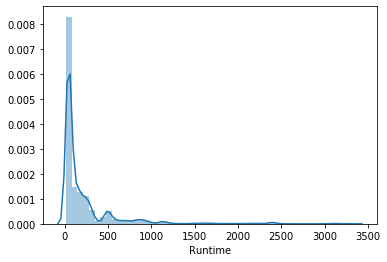

In [13]:
#plotting the distribution of Runtime
sns.distplot(df['Runtime']);

In [ ]:
#df.to_csv("cleaned.csv")

#### Making two different objects one which holders all the features and other which holds our target or dependent variable.
We have used minmax scaler on the our target variable so that we will have same range with the predicted data from the model and our y. We will be converting all the data into the tensor.

In [14]:
features = torch.tensor(df[df.columns[:-2]].values)
target = sklearn.preprocessing.minmax_scale(df["Runtime"], feature_range=(0, 1), axis=0, copy=True)
target = torch.tensor(target)

#### Calling train test split function of the scikit-learn to divide the data into two parts where 80% of the data lies in training and rest 20% in the testing.

In [17]:
train_features,test_features,train_target,test_target= train_test_split(features, target, test_size = 0.3,random_state=100)
#train_features,test_features,train_target,test_target= train_test_split(train_features, train_target, test_size = 0.3,random_state=100)

In [22]:
train_features.shape

torch.Size([101472, 13])

### Making a dataloader object
For making a dataloader object, we will first create a dataset class which uses the superclass from torce.utils.data. We will use below class to make a object of dataset class and will use this object to create a object of dataloader.

In [18]:
class DatasetT(T.Dataset):
   
    def __init__(self, features,labels):
        'Initialization'
        self.X = features
        self.Y = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)
   
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = self.X[index]
        y = self.Y[index]

        return x,y

In [19]:
trainset = DatasetT(train_features,train_target)
testset = DatasetT(test_features,test_target)



#### Making Dataloader object with batchsize as the number of instances in dataset

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=int(len(trainset)/10), 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                           batch_size=int(len(testset)), 
                                           shuffle=True)

In [21]:
##Changing different layers 

## Part I - Varying number of weights

### Varying the number of nodes in network.
For the above problem, we will build a simple one hidden layer network with input node as 13 and output node as 1. We will vary the hidden layer node by using a for loop. We will start from 26 nodes in hidden layer and will keep increasing linearly till 74 nodes in hidden layer.

### Model Class

In [33]:
class NetworkNode(nn.Module):
    def __init__(self,node1):
        super().__init__()
        self.fc1 = nn.Linear(13, node1)
        self.fc3 = nn.Linear(node1, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc3(x)
        return x

#### We will initialise two empty list for model mse and model computation time. 

In [34]:
criterion = nn.MSELoss()

modelMSE = []
modelComputations = []

In [35]:
for i in range(1,50):
    #initializing model
    model = NetworkNode(25+i)
    #initilizing Adam optimizer
    optm = Adam(model.parameters(), lr = 0.005)
    #starting the timer
    time_start = time.process_time()
    #training the model for 50 epoch
    for epoch in range(50):
        for i, (x, y) in enumerate(train_loader):
            optm.zero_grad()                   
            outputs = model(x.float())                        
            loss = criterion(outputs, y.float())            
            loss.backward()                         
            optm.step() 
    #stopping the timer since the training has finished
    modelComputations.append((time.process_time() - time_start))
    
    test_mse = []
    with torch.no_grad():
        for x,y in test_loader:
            yPred =[]
            yA = []
            output = model(x.float()) 
            yPred.append(output)
            yA.append(y)
            test_mse.append(mean_squared_error(yA[0].detach().numpy(), yPred[0].detach().numpy()))
        #saving the test mse in the modelMSE list
        modelMSE.append(test_mse)

C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they 

C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the

C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they 

C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the

C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they 

#### We will save out data in a csv file so that we will not have to do the computation again. We will use the data from csv file for plotting.

In [95]:
NumberNodes = [(25+i) for i in range(1,50)]
modelMSEs = [x[0] for x in modelMSE]
data = {"#Nodes":NumberNodes,"MSE": modelMSEs,"Computation":list(modelComputations)}
df2 = pd.DataFrame(data)
df2.to_csv("NodesVariations.csv")

#### Loading data from the csv which contains out results from above computations

In [99]:
df2 = pd.read_csv("NodesVariations.csv")

In [100]:
df2.head(2)

,Unnamed: 0,#Nodes,MSE,Computation
0,0,26,0.012858,1016.375000
1,1,27,0.012383,1039.609375


### Best MSE in part 1

In [197]:
df2[df2['MSE']==df2.MSE.min()]

,Unnamed: 0,#Nodes,MSE,Computation
6,6,32,0.010676,1016.15625


### Best model summary

In [222]:
class NetworkNode(nn.Module):
    def __init__(self,node1):
        super().__init__()
        self.fc1 = nn.Linear(13, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc3(x)
        return x

from torchsummary import summary
summary(NetworkNode(32), input_size=(101472,13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 101472, 32]             448
            Linear-2            [-1, 101472, 1]              33
Total params: 481
Trainable params: 481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.03
Forward/backward pass size (MB): 25.55
Params size (MB): 0.00
Estimated Total Size (MB): 30.58
----------------------------------------------------------------


Above summary is our model summary which gives us necessary information about the how many parameters we have in our model and how much size our model takes after being completed.

### Visualization of Part 1
We will plot two different plots for our results. First plot will have two figures representing the relation between number of weights vs MSE and number of weights vs time computations. In the second plot we will plot both of these result on a single figure with two y-axis one of either side.

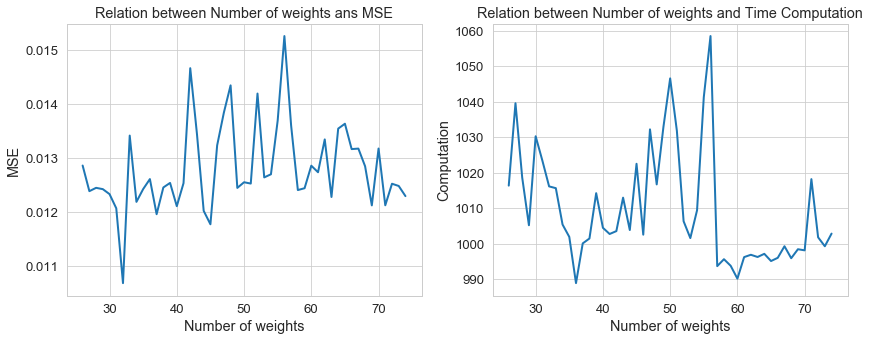

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})
sns.lineplot(x ="#Nodes", y="MSE",data=df2,ax=ax1)
sns.lineplot(x ="#Nodes", y="Computation",data=df2,ax=ax2)
#ax1.set_style('whitegrid')
ax1.set_xlabel("Number of weights")
ax2.set_xlabel("Number of weights")
ax1.set_title("Relation between Number of weights and MSE")
ax2.set_title("Relation between Number of weights and Time Computation");

In [196]:
#Creating legend for our plot
blue_patch = mpatches.Patch(color='blue', label='MSE')
green_patch = mpatches.Patch(color='green', label='Computation Time')

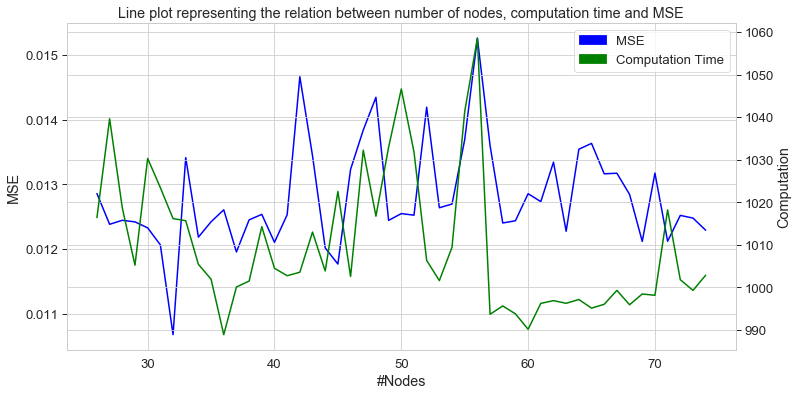

In [194]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.lineplot(x ="#Nodes", y="MSE",data=df2,color="b",markers= ["o"],dashes=False)
ax2 = plt.twinx()
sns.lineplot(x ="#Nodes", y="Computation",data=df2,color="g", ax=ax2)
sns.set_style('whitegrid')
plt.legend(handles=[blue_patch,green_patch])
plt.title("Line plot representing the relation between number of nodes, computation time and MSE")
plt.xlabel("Number of nodes");

### Conclusion of first part

By carefully observing the above two plots, there is no direct relation between the number of weights and the computation required. We got our best MSE with 32 weights. The computation time required to obtain best accuracy was compratively higher. Total 1016 ms of computation time was required in training the model with the 32 weights. But in our entire experiement it was the first time we got our MSE less than 0.011, all other result shows relatively high MSE. 

Increasing the number of weights does help but to some extend. As we can observe that, MSE began to decrease slowly as we keep on increasing the number of weights linearly but after 32, it suddenly rose to very high value. Therefore, in my conclusion of the first part increasing number of weight does help in getting the best result which is decreasing the MSE. 

## Part II - Varying number of layers

### Model class
Below is the network with one input layer, one output layer and one hidden layer. Our input layer has 6 neurons which is equal to the number of features in our dataset. Hidden layer consists of 2d dimensions which is 12 input neurons and one output neuron for output. We have sigmoid activation as directed in the assignment document

In [51]:
class Network1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 28)
        self.fc2 = nn.Linear(28, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 28)
        self.fc2 = nn.Linear(28, 13)
        self.fc3 = nn.Linear(13, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

class Network3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 28)
        self.fc2 = nn.Linear(28, 48)
        self.fc3 = nn.Linear(48, 28)
        self.fc4 = nn.Linear(28, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

class Network4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 28)
        self.fc2 = nn.Linear(28, 48)
        self.fc3 = nn.Linear(48, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return x
    
class Network5(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 28)
        self.fc2 = nn.Linear(28, 48)
        self.fc3 = nn.Linear(48, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 13)
        self.fc6 = nn.Linear(13, 1)
        

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = self.fc6(x)
        return x

class Network6(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 24)
        self.fc2 = nn.Linear(24, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 24)
        self.fc7 = nn.Linear(24, 1)
        

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        x = self.fc7(x)
        return x
    
class Network7(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 24)
        self.fc2 = nn.Linear(24, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 13)
        self.fc8 = nn.Linear(13, 1)
        

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        x = torch.sigmoid(self.fc7(x))
        x = self.fc8(x)
        return x

class Network8(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 24)
        self.fc2 = nn.Linear(24, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 24)
        self.fc9 = nn.Linear(24, 1)
        

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        x = torch.sigmoid(self.fc7(x))
        x = torch.sigmoid(self.fc8(x))
        x = self.fc9(x)
        return x

#### We will make a list of all the models.

In [52]:
model1 = Network1()
model2 = Network2()
model3 = Network3()
model4 = Network4()
model5 = Network5()
model6 = Network6()
model7 = Network7()
model8 = Network8()
networks = [model1,model2,model3,model4,model5,model6,model6,model8]

#### We had initialize our loss function and two empty list one for MSE and other for our computation time.

In [53]:
criterion = nn.MSELoss()
modelMSE = []
modelComputations = []

Below code will call each model from our list and will train the model and stores its computation time. After successfully completion of training, we will calculate our MSE on the test data and the best result is appended in the list.

In [54]:
for network in networks:
    #initializing the model
    model = network
    #initializing the adam optimizer
    optm = Adam(model.parameters(), lr = 0.005)
    #starting the timer
    time_start = time.process_time()
    for epoch in range(50):
        for i, (x, y) in enumerate(train_loader):
            optm.zero_grad()                   
            outputs = model(x.float())                        
            loss = criterion(outputs, y.float())            
            loss.backward()                         
            optm.step() 
    #stopping the timer since the training has finished
    modelComputations.append((time.process_time() - time_start))
    
    test_mse = []
    with torch.no_grad():
        for x,y in test_loader:
            yPred =[]
            yA = []
            output = model(x.float()) 
            yPred.append(output)
            yA.append(y)
            test_mse.append(mean_squared_error(yA[0].detach().numpy(), yPred[0].detach().numpy()))
        #saving the mse in our list
        modelMSE.append(test_mse)

C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\laxma\.conda\envs\Python\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10147])) that is different to the input size (torch.Size([10147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they 

#### We will save out data in a csv file so that we will not have to do the computation again. We will use the data from csv file for plotting.

In [170]:
layers = [1,2,3,4,5,6,7,8]
layersChanged = {'layers':layers,'MSE':modelMSE,'Computations':modelComputations}
df3 = pd.DataFrame(layersChanged)
df3.to_csv("VariationWithLayers.csv")

#### Loading data from the csv which contains out results from above computations

In [171]:
df3 = pd.read_csv("VariationWithLayers.csv")

In [172]:
df3.head()

,Unnamed: 0,layers,MSE,Computations
0,0,1,0.013190,1011.687500
1,1,2,0.013218,1003.453125
2,2,3,0.012253,1052.546875
3,3,4,0.012258,1061.000000
4,4,5,0.012858,1057.609375


### Best MSE in part II

In [200]:
df3[df3['MSE']==df3.MSE.min()]

,Unnamed: 0,layers,MSE,Computations
2,2,3,0.012253,1052.546875


### Visualization of Part 2
We will plot two different plots for our results. First plot will have two figures representing the relation between number of layers vs MSE and number of layers vs time computations. In the second plot we will plot both of these result on a single figure with two y-axis one of either side.

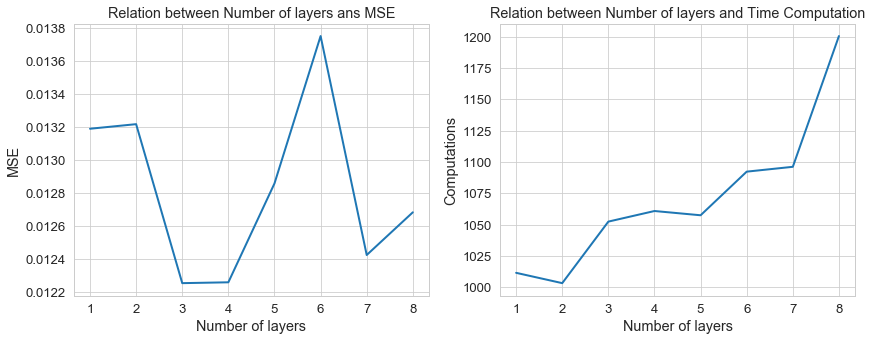

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})
sns.lineplot(x ="layers", y="MSE",data=df3,ax=ax1);
sns.lineplot(x ="layers", y="Computations",data=df3,ax=ax2)
#ax1.set_style('whitegrid')
ax1.set_xlabel("Number of layers")
ax2.set_xlabel("Number of layers")
ax1.set_title("Relation between Number of layers ans MSE")
ax2.set_title("Relation between Number of layers and Time Computation");

In [198]:
#Creating legend for our plot
blue_patch = mpatches.Patch(color='blue', label='MSE')
green_patch = mpatches.Patch(color='green', label='Computation Time')

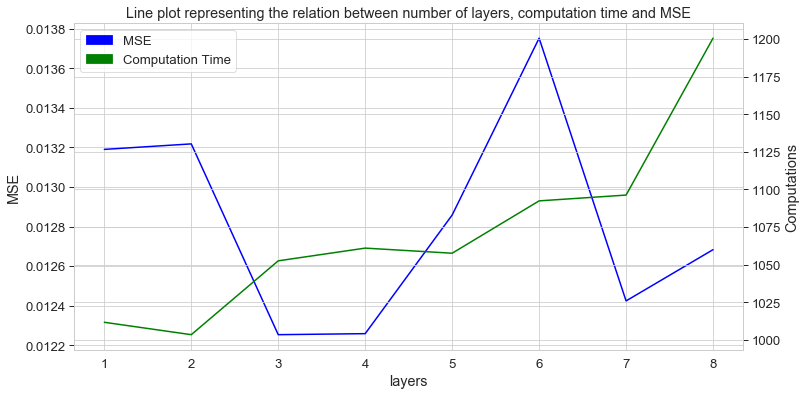

In [202]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.lineplot(x ="layers", y="MSE",data=df3,color="b",markers= ["o"],dashes=False)
ax2 = plt.twinx()
sns.lineplot(x ="layers", y="Computations",data=df3,color="g", ax=ax2)
sns.set_style('whitegrid')
plt.xlabel("Number of layers")
plt.legend(handles = [blue_patch,green_patch])
plt.title("Line plot representing the relation between number of layers, computation time and MSE");

### Conclusion of Part II

By carefully observing the above two plots, there is no direct relation between the number of layers and the MSE. But we can see that, as we keep on increasing the number of layers computation time requires increases. Increasing the number of layers, increases the computation and overall memory requirement exponentially. 

For explanation, I am taking summary of two model, one with just 2 layers and other with 8 layers. Our input data size is fixed and consist of 5 mb. Memory required for forward and backward pass in model with 2 layers is 32.52 mb while the memory required by the model with 8 layers is 483 mb which is more than 15 times. By just increasing the number of layers from 2 to 8, memory requirement increased to 15 times. Also, there are very few number of total parameters (783) in our first model which is with 2 layers. On the other hand, there are 63,937 total number of parameters in the second model (with 8 layers).

<b>Summary of model with 2 layers</b>
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1           [-1, 101472, 28]             392
            Linear-2           [-1, 101472, 13]             377
            Linear-3            [-1, 101472, 1]              14
================================================================
Total params: 783
Trainable params: 783
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.03
Forward/backward pass size (MB): 32.52
Params size (MB): 0.00
Estimated Total Size (MB): 37.55
----------------------------------------------------------------
```
<b>Summary of model with 8 layers</b>
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1           [-1, 101472, 24]             336
            Linear-2           [-1, 101472, 32]             800
            Linear-3           [-1, 101472, 64]           2,112
            Linear-4          [-1, 101472, 128]           8,320
            Linear-5          [-1, 101472, 256]          33,024
            Linear-6           [-1, 101472, 64]          16,448
            Linear-7           [-1, 101472, 32]           2,080
            Linear-8           [-1, 101472, 24]             792
            Linear-9            [-1, 101472, 1]              25
================================================================
Total params: 63,937
Trainable params: 63,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.03
Forward/backward pass size (MB): 483.86
Params size (MB): 0.24
Estimated Total Size (MB): 489.13
----------------------------------------------------------------
```

<b>We got our best MSE with 3 layers. The computation time required to obtain best accuracy was compratively higher. Total 1052 ms of computation time was required in training the model with the 3 layers.</b>

## Overall Conclusion

We were able to achieve the 0.01 MSE with the network structure of one layer with 32 nodes. We trained the model for 50 epoch on the 70% of our data. Computational efforts required to trained the model for obtaining the best MSE is also comparitively good. Totol 1016 ms was required to successfully complete the training. We tried increasing the weight of hidden layer to 74 but none of the weight was able to achieve the MSE lower 0.02. We also tried increasing the number of hidden layer from 1 hidden layer to 8 hidden layer and we achived the best result at 3 layers which was 0.0122 but was still higher than 0.0101 which we got from one hidden layer with 32 nodes.

<b> Best Model Structure</b>
```
NetworkNode(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
```

<b>Best Model Summary</b>
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1           [-1, 101472, 32]             448
            Linear-2            [-1, 101472, 1]              33
================================================================
Total params: 481
Trainable params: 481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.03
Forward/backward pass size (MB): 25.55
Params size (MB): 0.00
Estimated Total Size (MB): 30.58
----------------------------------------------------------------
```

Above is the summary of our best model, which gives us the necessary information about the model. We can observe that forward and backward pass occupies 5 times the size of our input. Our model occupies total 30 mb of our system while being run and after completion. There are only 481 total number of parameters and we got the MSE of 0.01 while in the earlier explanation with 783 and 63000 total parameters we weren't able to achieve the same.

In the end, I want to one final statement which is understood by me in the above experiement. Varying the number of weights and number of layers are very crucial set of hyperparameters. Tuning both the hyperparameters appropriately can help us tp acheive very good results. Like in our case, with some default weights and 3 layers we weren't able to achieve as good accuracy as model with one layer with finely tuned number of weights.